In [680]:
import gdal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#my code
from raster_sample import *
from profile_map_scanner import *




In [14]:
#send pd dataframe to csv for plotting in arc

creek= "Cache_creek_clip_MChiSegmented_whole_basin.csv"
read_path = "/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Cache_creek/"+creek#+"/" #Set path to data
#Creek name for M_chi segmented files
creek_data = np.genfromtxt((read_path), delimiter=',', skip_header=1, names=['node','row','col','latitude','longitude','chi','elevation','flow_distance','drainage_area','m_chi','b_chi','source_key','basin_key','segmented_elevation'])
#+name])
#+name
creek_data_df = pd.DataFrame(creek_data)
#convert to UTM
creek_data_df = convert_lat_long(creek_data_df)

pd.set_option('display.float_format', lambda x: '%.3f' % x)#remove scientific notation !!!!!
creek_data_df

write_path = '/Users/bmelosh/Documents/ArcGIS/Coast_Ranges/Cache_Creek/'
creek_data_df.to_csv('Cache_creek_m_chi.csv')



In [681]:
#Import the RASTER data
raster_path = "/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Cache_creek/"
raster = gdal.Open(raster_path + "/Cache_creek_clip_HS.bil")#Get raster data
dem = raster.ReadAsArray()

## IMPORT point DATA
creek= "Crack_canyon"
path = "/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Cache_creek/Previous_LSDTT_version/Channel_extraction/"+creek+"/" #Set path to data
name = creek+"_MChiSegmented.csv" #Set file name
creek_data = np.genfromtxt((path+name), delimiter=',', skip_header=1, names=['node', 'row', 'col', 'latitude', 'longitude', 'chi', 'elevation', 'flow_distance', 'drainage_area', 'm_chi', 'b_chi', 'source_key', 'basin_key', 'segmented_elevation'])


#Create pandas dataframe
creek_data_df = pd.DataFrame(creek_data)

#Create a distance column in pandas dataframe
#distance = creek_data_df['flow_distance'] - creek_data_df['flow_distance'].min()
#creek_data_df['distance'] = distance

#convert the lat long to utm from creek data, chi segmented (only need this if there is no x, y columns)
creek_data_df = convert_lat_long(creek_data_df)



In [678]:
#Create a bokeh plot of the raster
import bokeh.plotting as bp
from bokeh.plotting import figure, show, output_file
from bokeh.layouts import gridplot, column


#pull out the products of raster subsampler
X,Y, array = raster_subsample_xy_generator(raster, creek_data_df)

#Create a bokeh source to use in interactive plots
source=bp.ColumnDataSource(creek_data_df)
color_by_variable('m_chi', source=source) #define color scheme for profiles

#define boundaries of the data
x_range, y_range = define_boundaries(source)
elev_range = define_elevation_boundaries(source)


#Create profile plots 

p = stream_map_raster(array, source, title='Map',x_axis_label='Easting', y_axis_label='Northing')

p2 = profile(elev_range, source, title='Elevation profile', x_axis_label='Distance', y_axis_label='Elevation')

p3 = profile(elev_range, source, x='chi', title='Chi profile', x_axis_label='Chi', y_axis_label='Elevation')


output_file("Profile comparison.html", title="Creek scanner")

plotcol = column(p2, p3)
grid = gridplot([[p, plotcol]])

bp.show(grid)  


NameError: name 'raster_subsample_xy_generator' is not defined

In [37]:

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors



In [38]:
#IMPORT MOVERN FILE WITH ALL THE DIFFERENT CHI VALUES FOR EACH M/N RATIO
creek =  'Perkins_creek'
path = '/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Cache_creek/Previous_LSDTT_version/Channel_extraction/'+creek+'/'
name = creek+'_movern.csv'
#Import Data
creek_movern_df = pd.read_csv((path+name), delimiter=',', header=0, names=['source_key','basin_key','elevation','m_over_n = 0.1','m_over_n = 0.2','m_over_n = 0.3','m_over_n = 0.4','m_over_n = 0.5','m_over_n = 0.6','m_over_n = 0.7','m_over_n = 0.8'])

creek_movern_df = creek_movern_df.rename(columns={'source_key': 'Tributary'})

#THIS SEPERATES OUT THE TRIBUTARY DATA
#creating dataframe of CHI data for all tributaries
creek_movern_df_tributaries = creek_movern_df[creek_movern_df['Tributary'] != 0]

creek_movern_tributaries_merge = pd.DataFrame()



In [206]:
#THIS LOADS THE MLE DATA FOR EACH M/N VALUE FOR EACH TRIBUTARY 

mle_data_i = []
chiMS = []
chi = []
TributariesMLE = []

#Create array of mn values to iterate through (start_mn, end_mn, number of mn values)
mn_values = [x / 10.0 for x in range(1, 9, 1)]#create a list of floats.


for mn in mn_values: 
    num = mn
    full_name = '%s%s_movernstats_%s_fullstats.csv' % (path, creek, num)

    name_mle = 'MLE m/n %s' % num
    name_rmse = 'RMSE m/n %s' % num

    mle_data = pd.read_csv(full_name, delimiter=',', header= 0,names=['basin_key', 'reference_source_key', 'test_source_key','MLE','RMSE'])

    mle_data = pd.DataFrame(mle_data)
    mle_data_i.append(mle_data)

    creek_movern_tributaries_merge_i = creek_movern_df_tributaries.merge(mle_data, left_on = "Tributary", right_on = "test_source_key")
            
    creek_movern_tributaries_merge[name_mle] = creek_movern_tributaries_merge_i['MLE']
    creek_movern_tributaries_merge[name_rmse] = creek_movern_tributaries_merge_i['RMSE']
    
    
    TributariesMLE_i = list(creek_movern_tributaries_merge[name_mle])
    
    TributariesMLE.append(TributariesMLE_i)
    
    MLE_array = np.asarray(TributariesMLE)
    this_cmap = plt.cm.Reds
    cNorm  = colors.Normalize(vmin=np.min(MLE_array), vmax=np.max(MLE_array))
    plt.cm.ScalarMappable(norm=cNorm, cmap=this_cmap)
    
    #pull out the chi - elevation data for the tributaries
    a = creek_movern_df[creek_movern_df['Tributary']!=0]
    elevation = a['elevation']
    chi_i = list(a['m_over_n = %s' % num])
    elevation = list(elevation)
    chi.append(chi_i)
    
    #pull out the chi - elevation data for the main stem
    b = creek_movern_df[creek_movern_df['Tributary']==0]
    elevationMS = b['elevation']
    chiMS_i = list(b['m_over_n = %s' % num])
    chiMS.append(chiMS_i)
    
    


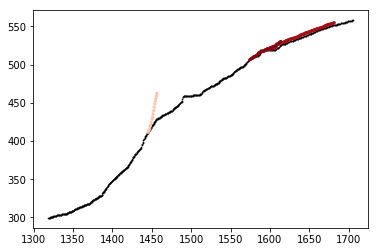

In [207]:
def multiplotter(num):

    plt.scatter(chiMS[num], elevationMS, c='k', s=0.5)
    plt.scatter(chi[num], elevation, c=TributariesMLE[num], cmap=this_cmap, norm=cNorm, s=10, edgecolors='none')

    plt.show()
    
    
multiplotter(1)

##OK this looks like i can do this in mpl now, what about bokeh slider?

In [854]:
###WORKING ON BOKEH PLOTS!!!

In [219]:
import numpy as np
import pandas as pd

from bokeh.io import curdoc
from bokeh.layouts import column, widgetbox
from bokeh.models import ColumnDataSource
from bokeh.models.widgets import Slider, TextInput
from bokeh.plotting import figure, show


#Function to import MLE data and create a dataframe with MLE data for all TRIBUTARIES for each M/N Value

creek = "Perkins_creek"
path = "/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Cache_creek/Previous_LSDTT_version/Channel_extraction/%s/" % creek#Set path to data
fname = creek+'_movern.csv'#name of movern file with all the chi data

#Create a function to pull in MLE data
mn_values = [x / 10.0 for x in range(1, 9, 1)]#create a list of floats.


def group_chi_mle_data(creek, path, fname, mn_values):
    #Import Chi Data
    movern_df = pd.read_csv((path+name), delimiter=',', header=0, names=['source_key','basin_key','elevation','m_over_n = 0.1','m_over_n = 0.2','m_over_n = 0.3','m_over_n = 0.4','m_over_n = 0.5','m_over_n = 0.6','m_over_n = 0.7','m_over_n = 0.8'])
    movern_df = movern_df.rename(columns={'source_key': 'Tributary'})
    movern_df_tribs = movern_df[movern_df['Tributary']!=0]
    movern_df_ms = movern_df[movern_df['Tributary']==0]

    #import MLE Data and merge with Chi
    mle_data_i = []
    mle_data_merge = pd.DataFrame()
    for mn in mn_values:

        movern_df = pd.read_csv((path+name), delimiter=',', header=0, names=['source_key','basin_key','elevation','m_over_n = 0.1','m_over_n = 0.2','m_over_n = 0.3','m_over_n = 0.4','m_over_n = 0.5','m_over_n = 0.6','m_over_n = 0.7','m_over_n = 0.8'])
        movern_df = movern_df.rename(columns={'source_key': 'Tributary'})
        movern_df_tribs = movern_df[movern_df['Tributary']!=0]


        full_name = '%s%s_movernstats_%s_fullstats.csv' % (path, creek, mn)

        name_mle = 'MLE m/n %s' % mn
        name_rmse = 'RMSE m/n %s' % mn

        mle_data = pd.read_csv(full_name, delimiter=',', header= 0,names=['basin_key', 'reference_source_key', 'test_source_key','MLE','RMSE'])

        mle_data = pd.DataFrame(mle_data)
        mle_data_i.append(mle_data)

        mle_data_merge['test_source_key'] = mle_data['test_source_key']
        mle_data_merge[name_mle] = mle_data['MLE']
        mle_data_merge[name_rmse] = mle_data['RMSE']

        movern_df_tribs_merge = movern_df_tribs.merge(mle_data_merge, left_on = "Tributary", right_on = "test_source_key")

    return movern_df_tribs_merge, movern_df_ms, mle_data_merge



In [259]:
tribs, main_stem, mle_data_merge = group_chi_mle_data(creek, path, fname, mn_values)

tribs_mle = []
for mn in mn_values:
    tribs_i = list(tribs['MLE m/n %s' % mn]) #turn df into list
    tribs_mle.append(tribs_i)#create list of mle lists for coloring graphs
    
MLE_array = np.asarray(tribs_mle)
this_cmap = plt.cm.Reds
cNorm  = colors.Normalize(vmin=np.min(MLE_array), vmax=np.max(MLE_array))
plt.cm.ScalarMappable(norm=cNorm, cmap=this_cmap)



In [198]:
from bokeh.io import curdoc
from bokeh.layouts import column, widgetbox
from bokeh.models import ColumnDataSource
from bokeh.models.widgets import Slider, TextInput
from bokeh.plotting import figure, show

In [204]:
#assign bokeh data sources
souce_tribs = ColumnDataSource(tribs)
source = ColumnDataSource(main_stem)


# Set up plot
plot = figure(plot_height=250, plot_width=500, title=creek, x_axis_label='Chi (X)', y_axis_label='Elevation (m)',
              tools="pan,reset,save,wheel_zoom")
plot.circle('m_over_n = 0.1', 'elevation', source=source_ms, fill_color = )

#show(plot)
# # Set up widgets
mn_values_slider = Slider(title="m/n values", value=0.0, start=0.1, end=0.8, step=0.1)


# Set up callbacks
def update_data(attrname, old, new):

    # Get the current slider values
    mn = mn_values_slider.value


    # Generate the new curve
    x = source_ms.data['m_over_n = %s' % mn]['chi']
    y = source_ms.data['elevation']

    source_ms.data = dict(x=x, y=y)

for mn in [mn_values_slider]:
    mn.on_change('value', update_data)

# Set up layouts and add to document
inputs = widgetbox(mn_values_slider)

curdoc().add_root(column(inputs, plot, width=800))
curdoc().title = "m/n values"

In [268]:

#"High level" bokeh plot of tributary data

import bokeh.plotting as bp
bp.output_notebook()
import bokeh.charts

p = bokeh.charts.Scatter(tribs, x='m_over_n = 0.1', y='elevation', color='MLE m/n 0.1',
                        tools="crosshair, hover, wheel_zoom, pan")
p2 = bokeh.charts.Scatter(main_stem, x='m_over_n = 0.1', y='elevation', color='darkgray', 
                          tools="crosshair, hover, wheel_zoom, pan")
show(p)

Loading BokehJS ...

In [297]:
import bokeh.plotting as bp

p = bp.figure(title="simple scatter plot")
p.scatter(x=tribs['m_over_n = 0.1'].values, y=tribs.elevation.values)
#bp.show(p)


import matplotlib as mpl

s = tribs.groupby(by='elevation').size()
cmap = list(s.index.values)

color_index = pd.Series([cmap.index(item) for item in tribs.elevation.values])
norm = mpl.colors.Normalize()
norm.autoscale(color_index)
sm = mpl.cm.ScalarMappable(norm, 'jet')

colors = [
    "#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g, b, a in [sm.to_rgba(item, bytes=True) for item in color_index]
]

import bokeh.models as bm

source = bm.ColumnDataSource(
        data=dict(
            x=tribs['m_over_n = 0.1'].values,
            y=tribs.elevation.values,
            c=colors
        )
    )

source_ms = bm.ColumnDataSource(
            data=dict(
                x=main_stem['m_over_n = 0.1'].values,
                y=main_stem.elevation.values))


p = bp.figure(title="Vélib stations in Paris", 
              tools="hover, pan, wheel_zoom")
p.circle(x='x', y='y', fill_color='darkgray', line_color=None, source=source_ms)
p.circle(x='x', y='y', fill_color='c', size=10, line_color=None, source=source)

bp.show(p)
